In [1]:
import os as os
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import platform
from sympy import *
from random import randrange
import tensorflow as tf
from scipy.signal import savgol_filter

In [2]:
import keras
from keras.models import Model, load_model
from keras.models import Sequential
from keras.layers import  Conv2D, MaxPool2D, Input, Dense, Dropout, Reshape, Flatten, Add, Lambda, \
    LSTM, GRU, Conv1D, Concatenate, TimeDistributed
from keras import initializers
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model

In [3]:
#Generate solution for given initial conditions
def solver(nx=40,nt=99,x_len=1,t_len=0.2,plot=True ):
  
    #  Set parameters.
    nx = nx
    nt = nt
    x_length = x_len
    t_length = t_len
    g = 9.8
    
    #  Compute H and UH.
    
    h = np.zeros ( nx )
    uh = np.zeros ( nx )
    hm = np.zeros ( nx - 1 )
    uhm = np.zeros ( nx - 1 )
    x = np.zeros ( nx )
    t = np.zeros ( nt + 1 )
    h_array = np.zeros ( [ nx, nt + 1 ] )
    uh_array = np.zeros ( [ nx, nt + 1 ] )
    #
    #  Define the locations of the nodes and time steps and the spacing.
    #
    x = np.linspace ( 0, x_length, nx )
    t = np.linspace ( 0, t_length, nt + 1 )

    dx = x_length / float ( nx - 1 )
    dt = t_length / float ( nt )
    #  Apply the initial conditions.
    h = initial_conditions ( nx, x )
    uh=np.zeros(nx)
    
    #  Apply the boundary conditions.
    h[0] = h[nx-2]
    h[nx-1] = h[1]
    uh[0] = uh[nx-2]
    uh[nx-1] = uh[1]
    
   

    h_array[0:nx,0] = h[0:nx]
    uh_array[0:nx,0] = uh[0:nx]
    
    #  Take NT more time steps.
    for it in range ( 1, nt + 1 ):
    
    #  Take a half time step, estimating H and UH at the NX-1 spatial midpoints.
        hm[0:nx-1] = ( h[0:nx-1] + h[1:nx] ) / 2.0 \
          - ( dt / 2.0 ) * ( uh[1:nx] - uh[0:nx-1] ) / dx

        uhm[0:nx-1] = ( uh[0:nx-1] + uh[1:nx] ) / 2.0 \
          - ( dt / 2.0 ) * ( \
            uh[1:nx] ** 2    / h[1:nx]   + 0.5 * g * h[1:nx] ** 2 \
          - uh[0:nx-1] ** 2  / h[0:nx-1] - 0.5 * g * h[0:nx-1] ** 2 ) / dx
        
        #  Take a full time step, evaluating the derivative at the half time step,
        #  to estimate the solution at the NX-2 nodes.
      
        h[1:nx-1] = h[1:nx-1] \
          - dt * ( uhm[1:nx-1] - uhm[0:nx-2] ) / dx

        uh[1:nx-1] = uh[1:nx-1] \
          - dt * ( \
            uhm[1:nx-1] ** 2  / hm[1:nx-1] + 0.5 * g * hm[1:nx-1] ** 2 \
          - uhm[0:nx-2] ** 2  / hm[0:nx-2] - 0.5 * g * hm[0:nx-2] ** 2 ) / dx
        
        #  Update the boundary conditions.
        
        h[0] = h[nx-2]
        h[nx-1] = h[1]
        uh[0] = uh[nx-2]
        uh[nx-1] = uh[1]

        #  Copy data into the big arrays.

        h_array[0:nx,it] = h[0:nx]
        uh_array[0:nx,it] = uh[0:nx]

    x_min = min ( x )
    x_max = max ( x )

    h_min = 0.0
    h_max = np.amax ( h_array )

    uh_max = np.amax ( uh_array )
    uh_min = np.amin ( uh_array )
    
    if plot == True:
      #  Animation of H.
      for it in range ( 0, nt + 1 ):
          if it % 100 == 0:

              plt.axis ( [ x_min, x_max, h_min, h_max ] )
              plt.fill_between ( x, 0, h_array[:,it] )
              title_string = ( 'H(T), Step %3d, Time = %f' % ( it, t[it] ) )
              plt.title ( title_string )
              plt.xlabel ( 'X' )
              plt.ylabel ( 'H(X,T)' )
              plt.show ( block = False )
          
      #  Animation of UH.
      for it in range ( 0, nt + 1 ):
          if it % 100 == 0:

              plt.axis ( [ x_min, x_max, h_min, h_max ] )
              plt.fill_between ( x, 0, uh_array[:,it] )
              title_string = ( 'UH(T), Step %3d, Time = %f' % ( it, t[it] ) )
              plt.title ( title_string )
              plt.xlabel ( 'X' )
              plt.ylabel ( 'UH(X,T)' )
              plt.show ( block = False )
   
      print ( 'Normal end of execution.' )

    return h_array, uh_array, x, t


In [4]:
#Random ICs
def initial_conditions ( nx, x ):

    H0=10
    x_max= np.amax(x)
    bumps=randrange(1,5)
    amp = np.random.rand(bumps)* (0.01*H0)
    pos = np.random.rand(bumps)*(0.75*x_max) + (0.125*x_max)
    Dissapation = 300

    Gaussian = H0*np.ones(nx)
    for i in range(len(amp)):
      if i%2 == 0:
        Gaussian += amp[i]*np.exp(-Dissapation*(x-pos[i])**2)

      elif i%2 != 0:
        Gaussian -= amp[i]*0.5*np.exp(-Dissapation*(x-pos[i])**2)
    
    h =  Gaussian
    return h

#Take only every n step in time and space
def prep_data(h,u,x,t,n):
    
    h= np.transpose(h[::n,::n])
    u= np.transpose(u[::n,::n])
    x=x[::n]
    t=t[::n]
    
    
    training_h= np.zeros(len(x)*(len(t)-1)).reshape(len(t)-1,len(x))
    labels_h=   np.zeros(len(x)*(len(t)-1)).reshape(len(t)-1,len(x))

    training_u= np.zeros(len(x)*(len(t)-1)).reshape(len(t)-1,len(x))
    labels_u=   np.zeros(len(x)*(len(t)-1)).reshape(len(t)-1,len(x))

    
    for i in range(0,len(h)-1):
        training_h[i] = h[i]
        labels_h[i] = h[i+1]
    
    for i in range(0,len(u)-1):
        training_u[i] = u[i]
        labels_u[i] = u[i+1]

    t=t[:-1]
        
    return training_h, labels_h, training_u, labels_u, x, t

#Merge several data sets with different ICs into one set of data for generality
def generate_data (rounds,nx,x_length,t_length):

  nt=nx-1


  h_array, uh_array, x, t   = solver (nx=nx, nt=nt, x_len= x_length, t_len= t_length,plot=False)
  training_h, labels_h, training_u, labels_u, x, t = prep_data(h_array, uh_array, x, t,n=4)

  for i in range(rounds -1):

    h_array, uh_array, x, t=solver (nx=nx, nt=nt, x_len= x_length, t_len= t_length,plot=False)

    training_hTemp, labels_hTemp, training_uTemp, labels_uTemp, x, t= prep_data(h_array, uh_array, x, t,n=4)

    training_h =np.concatenate((training_h,training_hTemp),axis=0)
    labels_h= np.concatenate((labels_h,labels_hTemp),axis=0)
    training_u=np.concatenate((training_u,training_uTemp),axis=0)
    labels_u=np.concatenate((labels_u,labels_uTemp),axis=0)
 
 

  return training_h,labels_h, training_u, labels_u ,x,t

def normalize(data):
  min = np.amin(data)
  max = np.amax(data)
  data = (data-min)/(max-min)
  return data 

def standardize(data):
  μ = np.mean(data)
  std = np.std(data)
  data = (data-μ)/std
  return data

def prep_multi_step(array,p):
  new= []
  for i in range(0,len(array),p):
    step = array[i:p+i]
    new.append(step)
    
  return np.array(new)

In [5]:
def main_data(rounds,nx,x_len):

  nx=nx
  nt= 2*nx -1
  x_len= x_len
  t_len= x_len/15

  training_h,labels_h, training_u, labels_u,x,t  = generate_data (rounds,nx,x_len,t_len)

  training_h=normalize(training_h)
  labels_h=normalize(labels_h)
  training_u=normalize(training_u)
  labels_u=normalize(labels_u)

  return training_h,labels_h, training_u, labels_u,x,t


In [6]:
training_h,labels_h, training_u, labels_u,x,t= main_data(52,1024,1.5); 

In [18]:
def block(inp,nodes):
  b1= Dense(nodes,activation='tanh')(inp)
  b2= Dense(nodes,activation='tanh')(b1)

  output= Add()([inp,b2])
  
  return output

In [21]:
def mlp_resnet(nodes,blocks):
  input= Input(shape=[nodes])

  out= block(input,nodes)
  for i in range(blocks):
    out=block(out,nodes)

  model = Model([input], [out])   
  opt= keras.optimizers.Adam(learning_rate=0.001) 
  model.compile(optimizer=opt, loss='mse')

  return model
  


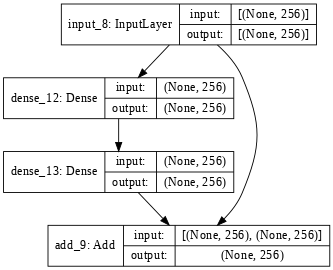

In [22]:
model= mlp_resnet(256,0)
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)
#model.summary()

In [ ]:
callback = EarlyStopping(monitor='mean_squared_error', patience=5)
hist=model.fit(training_u,labels_u,batch_size=4,epochs=16,validation_split=0.25,verbose=1)

Epoch 1/16
2487/2487 [==============================] - 7s 3ms/step - loss: 0.0087 - val_loss: 7.3511e-05
Epoch 2/16
2487/2487 [==============================] - 6s 2ms/step - loss: 4.5012e-05 - val_loss: 3.3637e-05
Epoch 3/16
2487/2487 [==============================] - 6s 2ms/step - loss: 2.9253e-05 - val_loss: 2.9858e-05
Epoch 4/16
2487/2487 [==============================] - 6s 2ms/step - loss: 2.6907e-05 - val_loss: 2.8008e-05
Epoch 5/16
2487/2487 [==============================] - 6s 2ms/step - loss: 2.6377e-05 - val_loss: 2.7899e-05
Epoch 6/16
2487/2487 [==============================] - 6s 2ms/step - loss: 2.5877e-05 - val_loss: 2.7869e-05
Epoch 7/16
2487/2487 [==============================] - 6s 2ms/step - loss: 2.6228e-05 - val_loss: 2.7812e-05
Epoch 8/16
2487/2487 [==============================] - 6s 2ms/step - loss: 2.5906e-05 - val_loss: 2.7768e-05
Epoch 9/16
2487/2487 [==============================] - 6s 3ms/step - loss: 2.5934e-05 - val_loss: 2.7750e-05
Epoch 10/16
24

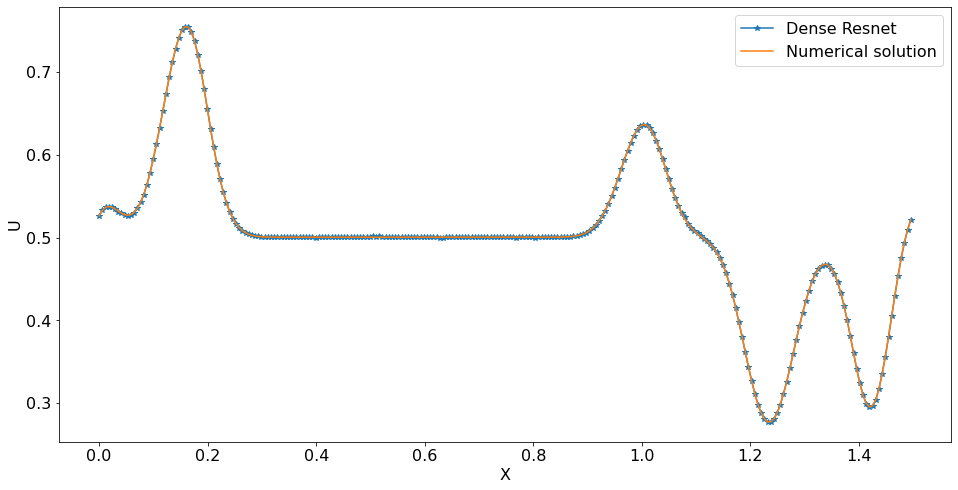

In [ ]:
#i=randrange(10,500)
#IC= (np.array([labels_h[i]]))
#pred=model(IC)

def pred_multistep(model,steps):
  i=randrange(10,500)
  pred= (np.array([labels_u[i]]))
  nn=[]
  labels=[]
  for j in range(steps):
    pred=model(pred)
    nn.append(pred)
    
    labels.append(labels_u[i+j])
  return np.array(nn),np.array(labels)

pred,labels=pred_multistep(model,1)
fig, axes = plt.subplots(figsize=(16,8))
plt.plot(x,pred[-1][0],'*-',label='Dense Resnet')
plt.plot(x,labels[-1],label='Numerical solution')
plt.xlabel("X")
plt.ylabel("U")
plt.legend()
plt.savefig('U Dense Res.pdf')
plt.show()

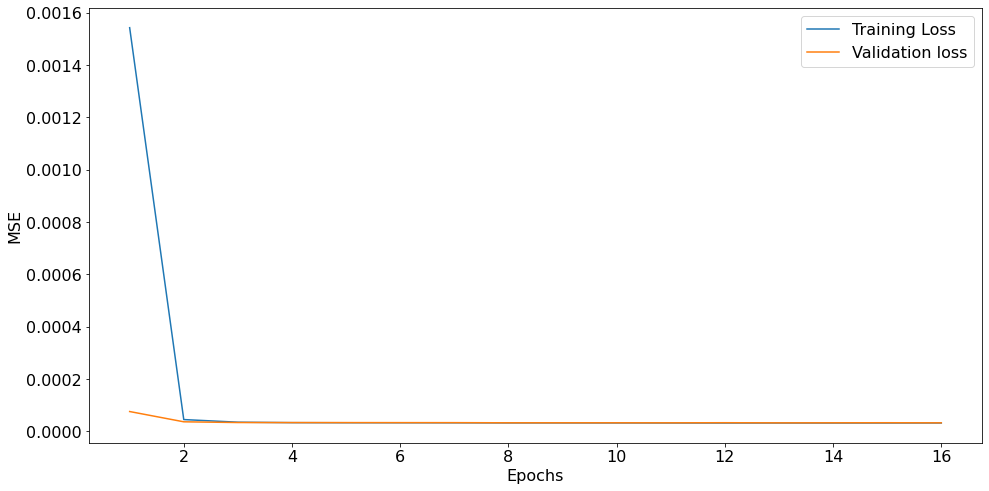

In [ ]:
loss=hist.history['loss']
val_loss=hist.history['val_loss']
epochs=np.linspace(1,16,16)
fig, axes = plt.subplots(figsize=(16,8))
plt.plot(epochs,loss,label='Training Loss')
plt.plot(epochs,val_loss,label='Validation loss')
#plt.title("Loss function per eoc")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()
plt.savefig('U loss Dense Res.pdf')  
plt.show()

In [ ]:
font = {'size'   : 16}
plt.rc('font', **font)

In [ ]:
plt.savefig('H Dense Res.pdf')

<Figure size 432x288 with 0 Axes>